In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import stat
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
import tensorflow as tf

In [2]:
bmd = pd.read_csv('building_metadata.csv')

In [3]:
bmd

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [4]:
full_df = pd.read_csv('train.csv',index_col='timestamp',parse_dates=True, infer_datetime_format=True)

In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [7]:
full_df

,building_id,meter,meter_reading
timestamp,,,
2016-01-01 00:00:00,0,0,0.000000
2016-01-01 00:00:00,1,0,0.000000
2016-01-01 00:00:00,2,0,0.000000
2016-01-01 00:00:00,3,0,0.000000
2016-01-01 00:00:00,4,0,0.000000
...,...,...,...
2016-12-31 23:00:00,1444,0,8.750000
2016-12-31 23:00:00,1445,0,4.825000
2016-12-31 23:00:00,1446,0,0.000000


In [8]:
full_df = full_df[full_df['meter']==0]

In [9]:
full_df = full_df.drop('meter', axis = 1)

In [10]:
full_df.head()

,building_id,meter_reading
timestamp,,
2016-01-01,0,0.0
2016-01-01,1,0.0
2016-01-01,2,0.0
2016-01-01,3,0.0
2016-01-01,4,0.0


In [11]:
full_df_piv = pd.pivot_table(full_df, index=full_df.index, columns='building_id')

In [12]:
full_df_piv

meter_reading                                              \
building_id                  0          1       2           3            4      
timestamp                                                                       
2016-01-01 00:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 01:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 02:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 03:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 04:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
...                           ...        ...     ...         ...          ...   
2016-12-31 19:00:00    232.070999  68.255997  4.9144  107.162003  1150.800049   
2016-12-31 20:00:00    189.069000  52.420601  5.3240  107.162003  1197.890015   
2016-12-31 21:00:00    169.957993  53.512699  5.7335  106.820999  1147.380005   
2016-12-31 22:00:00    169.957993  54.331799  4.9144  104.089996  1130.319946   
2016-12-31 23:00:00    175.417999  51.055500  4.9144  102.724998  1162.400024   

                                                                               \
building_id               5           6           7           8          9      
timestamp                                                                       
2016-01-01 00:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 01:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 02:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 03:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 04:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
...                        ...         ...         ...         ...        ...   
2016-12-31 19:00:00  10.238400  264.970001  550.825989  555.604004  61.430401   
2016-12-31 20:00:00  18.770399  265.378998  593.145020  577.445984  61.430401   
2016-12-31 21:00:00   9.214600  263.740997  557.992981  540.245972  63.068600   
2016-12-31 22:00:00  17.405300  258.826996  551.849976  513.968018  61.840000   
2016-12-31 23:00:00   8.873300  259.645996  535.468018  505.436005  61.840000   

                     ...                                                 \
building_id          ...        1439        1440        1441       1442   
timestamp            ...                                                  
2016-01-01 00:00:00  ...  201.600006  160.949997  248.524994  54.625000   
2016-01-01 01:00:00  ...  204.649994  165.250000  259.375000  63.224998   
2016-01-01 02:00:00  ...  202.774994  161.675003  250.475006  53.674999   
2016-01-01 03:00:00  ...  199.800003  164.850006  259.625000  58.075001   
2016-01-01 04:00:00  ...  197.699997  158.750000  247.399994  58.500000   
...                  ...         ...         ...         ...        ...   
2016-12-31 19:00:00  ...  176.524994  165.824997  245.675003  61.500000   
2016-12-31 20:00:00  ...  171.225006  163.875000  250.125000  55.474998   
2016-12-31 21:00:00  ...  169.725006  162.399994  247.875000  61.924999   
2016-12-31 22:00:00  ...  164.750000  154.699997  247.574997  58.349998   
2016-12-31 23:00:00  ...  167.399994  154.750000  242.925003  59.400002   

                                                                      
building_id               1443   1444   1445 1446        1447   1448  
timestamp                                                             
2016-01-01 00:00:00  57.724998  5.425  4.800  0.0  160.199997  2.325  
2016-01-01 01:00:00  63.349998  5.550  4.825  0.0  156.649994  2.225  
2016-01-01 02:00:00  62.875000  5.900  5.125  0.0  157.574997  2.275  
2016-01-01 03:00:00  64.250000  5.525  5.225  0.0  154.925003  2.575  
2016-01-01 04:00:00  64.675003  5.725  5.250  0.0  156.074997  3.075  
...                        ...    ...    ...  ...         ...    ...  
2016-12-31 19:00:00  83.724998  8.525  5.750  0.0  167.80000

In [13]:
full_df_piv.columns = full_df_piv.columns.droplevel()

In [14]:
full_df_piv.head()

building_id,0,1,2,3,4,5,6,7,8,9,...,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,201.600006,160.949997,248.524994,54.625000,57.724998,5.425,4.800,0.0,160.199997,2.325
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,204.649994,165.250000,259.375000,63.224998,63.349998,5.550,4.825,0.0,156.649994,2.225
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,202.774994,161.675003,250.475006,53.674999,62.875000,5.900,5.125,0.0,157.574997,2.275
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,199.800003,164.850006,259.625000,58.075001,64.250000,5.525,5.225,0.0,154.925003,2.575
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,197.699997,158.750000,247.399994,58.500000,64.675003,5.725,5.250,0.0,156.074997,3.075


In [15]:
mean_usage = full_df_piv.mean(axis = 0) 

In [16]:
mean_usage

building_id
0       146.454697
1        74.865501
2        14.551390
3       235.549988
4       976.557007
           ...    
1444      7.482129
1445      4.732813
1446      3.592165
1447    187.117889
1448      3.338596
Length: 1413, dtype: float32

In [17]:
type(mean_usage)

pandas.core.series.Series

In [18]:
mean_usage_df = mean_usage.to_frame(name='mean_usage')

In [19]:
mean_usage_df

,mean_usage
building_id,
0,146.454697
1,74.865501
2,14.551390
3,235.549988
4,976.557007
...,...
1444,7.482129
1445,4.732813
1446,3.592165


In [20]:
bmd

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [21]:
# Merge

merged = bmd.merge(mean_usage_df, left_index=True, right_index=True, how='inner')

In [22]:
merged

,site_id,building_id,primary_use,square_feet,year_built,floor_count,mean_usage
0,0,0,Education,7432,2008.0,NaN,146.454697
1,0,1,Education,2720,2004.0,NaN,74.865501
2,0,2,Education,5376,1991.0,NaN,14.551390
3,0,3,Education,23685,2002.0,NaN,235.549988
4,0,4,Education,116607,1975.0,NaN,976.557007
...,...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN,7.482129
1445,15,1445,Education,4298,NaN,NaN,4.732813
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN,3.592165
1447,15,1447,Lodging/residential,29775,2001.0,NaN,187.117889


In [23]:
merged.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448],
           dtype='int64', length=1413)

In [24]:
merged.isnull().any()

site_id        False
building_id    False
primary_use    False
square_feet    False
year_built      True
floor_count     True
mean_usage     False
dtype: bool

In [25]:
# 750 NaNs in series... that's quite alot -> will just remove
merged['year_built'].isna().sum()

750

In [26]:
# 1061 NaNs in series... that's quite alot -> will just remove
merged['floor_count'].isna().sum()

1061

In [27]:
merged.drop(['year_built', 'floor_count'], axis =1)

,site_id,building_id,primary_use,square_feet,mean_usage
0,0,0,Education,7432,146.454697
1,0,1,Education,2720,74.865501
2,0,2,Education,5376,14.551390
3,0,3,Education,23685,235.549988
4,0,4,Education,116607,976.557007
...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,7.482129
1445,15,1445,Education,4298,4.732813
1446,15,1446,Entertainment/public assembly,11265,3.592165
1447,15,1447,Lodging/residential,29775,187.117889


In [28]:
cleaned_df = merged.drop(['year_built', 'floor_count'], axis =1)

In [29]:
cleaned_df 

,site_id,building_id,primary_use,square_feet,mean_usage
0,0,0,Education,7432,146.454697
1,0,1,Education,2720,74.865501
2,0,2,Education,5376,14.551390
3,0,3,Education,23685,235.549988
4,0,4,Education,116607,976.557007
...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,7.482129
1445,15,1445,Education,4298,4.732813
1446,15,1446,Entertainment/public assembly,11265,3.592165
1447,15,1447,Lodging/residential,29775,187.117889


In [30]:
cleaned_df['mean_usage'].max()

4650.169921875

In [31]:
cleaned_df.describe()

,site_id,building_id,square_feet,mean_usage
count,1413.000000,1413.000000,1413.000000,1413.000000
mean,6.842180,714.958953,92204.792640,169.801117
std,4.985376,418.115709,111412.340117,334.306732
min,0.000000,0.000000,283.000000,0.000400
25%,3.000000,353.000000,22949.000000,26.393579
50%,5.000000,706.000000,57673.000000,71.222099
75%,13.000000,1073.000000,115288.000000,171.028519
max,15.000000,1448.000000,875000.000000,4650.169922


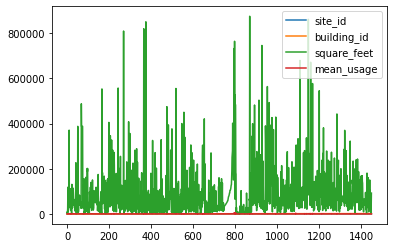

In [32]:
cleaned_df.plot()

In [33]:
# Later i can feature engineer something for these removed columns

In [34]:
# Huge discrepancy among mean energy usage!! -> Will train model on top 99%

In [35]:
#1413*0.99 -> around 1400

In [36]:
cleaned_df.nsmallest(1400,'mean_usage')

,site_id,building_id,primary_use,square_feet,mean_usage
740,5,740,Education,37975,0.000400
817,8,817,Entertainment/public assembly,984,0.171072
815,8,815,Entertainment/public assembly,666,0.175285
636,4,636,Education,6564,0.184486
637,4,637,Education,4189,0.200081
...,...,...,...,...,...
993,9,993,Education,428647,1398.935791
1159,13,1159,Office,671507,1422.077148
1156,13,1156,Education,259989,1479.001343
869,8,869,Entertainment/public assembly,875000,1513.606445


In [37]:
cleaned_df = cleaned_df.nsmallest(1400,'mean_usage')

In [38]:
cleaned_df['primary_use'].unique()

array(['Education', 'Entertainment/public assembly', 'Other',
       'Lodging/residential', 'Office', 'Public services',
       'Religious worship', 'Retail', 'Warehouse/storage',
       'Manufacturing/industrial', 'Parking', 'Healthcare', 'Services',
       'Technology/science', 'Utility', 'Food sales and service'],
      dtype=object)

In [39]:
#cleaned_df = cleaned_df.drop('site_id', axis = 1)

In [40]:
# Want to predict energy usage -> y

In [41]:
cleaned_df.index = cleaned_df['building_id']

In [42]:
new_cleaned = cleaned_df.drop(['site_id', 'building_id'], axis = 1)

In [43]:
cleaned_df.iloc[:,-1]

building_id
740        0.000400
817        0.171072
815        0.175285
636        0.184486
637        0.200081
           ...     
993     1398.935791
1159    1422.077148
1156    1479.001343
869     1513.606445
645     1538.965820
Name: mean_usage, Length: 1400, dtype: float32

In [44]:
new_cleaned

,primary_use,square_feet,mean_usage
building_id,,,
740,Education,37975,0.000400
817,Entertainment/public assembly,984,0.171072
815,Entertainment/public assembly,666,0.175285
636,Education,6564,0.184486
637,Education,4189,0.200081
...,...,...,...
993,Education,428647,1398.935791
1159,Office,671507,1422.077148
1156,Education,259989,1479.001343


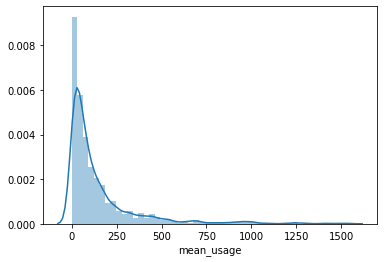

In [45]:
sns.distplot(new_cleaned['mean_usage'], bins = 50)

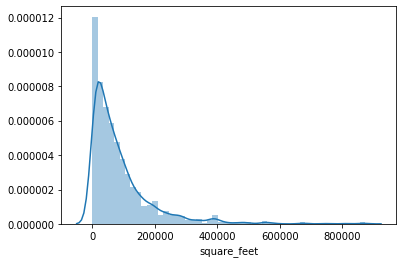

In [46]:
sns.distplot(new_cleaned['square_feet'], bins = 50)

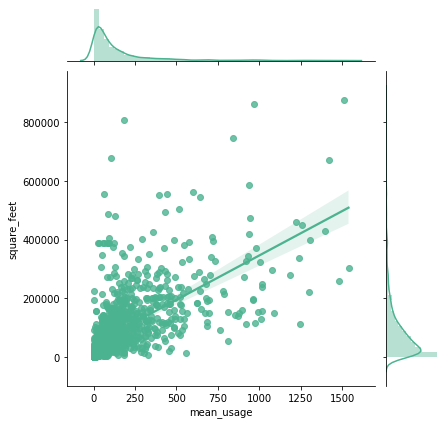

In [47]:
sns.jointplot(x=new_cleaned['mean_usage'], y=new_cleaned['square_feet'],kind="reg",color="#4CB391")

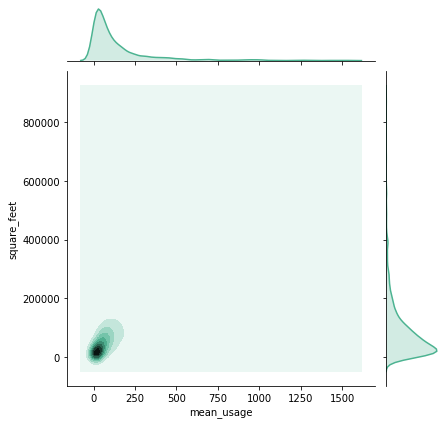

In [48]:
sns.jointplot(x=new_cleaned['mean_usage'], y=new_cleaned['square_feet'],kind="kde",color="#4CB391")

In [49]:
# There is no clear relationship between building size and usage...except for smaller buildings!

In [50]:
# Can one hot encode this

In [51]:
X = new_cleaned.iloc[:,0:-1].values
y = new_cleaned.iloc[:,-1].values

In [52]:
X

array([['Education', 37975],
       ['Entertainment/public assembly', 984],
       ['Entertainment/public assembly', 666],
       ...,
       ['Education', 259989],
       ['Entertainment/public assembly', 875000],
       ['Education', 304333]], dtype=object)

In [53]:
y

array([3.9999245e-04, 1.7107156e-01, 1.7528506e-01, ..., 1.4790013e+03,
       1.5136064e+03, 1.5389658e+03], dtype=float32)

In [54]:
# One Hot Encoding the "Primary Use" column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')


In [55]:
ct

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('encoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 [0])],
                  verbose=False)

In [56]:
X = ct.fit_transform(X).toarray()


In [57]:
X.shape

(1400, 17)

In [58]:
from sklearn.model_selection import train_test_split
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, **options)>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [108]:
#Now scale!
from sklearn.preprocessing import StandardScaler

In [109]:
scaler = StandardScaler()

In [110]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [111]:
#Get ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [112]:
X_train.shape

(1120, 17)

In [113]:
# Need 19 neurons per layer

In [114]:
model = Sequential()
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))
model.add(Dense(17,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [115]:
from tensorflow.keras.callbacks import EarlyStopping #Callback

In [116]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 25)
#Could maximise accuracy...

In [117]:
model.fit(x = X_train, y = y_train, epochs = 600, validation_data=(X_test,y_test),
         callbacks = [early_stop])

Epoch 1/600
35/35 [==============================] - 0s 5ms/step - loss: 65497.1367 - val_loss: 71143.9375
Epoch 2/600
35/35 [==============================] - 0s 3ms/step - loss: 64931.0352 - val_loss: 69334.2188
Epoch 3/600
35/35 [==============================] - 0s 3ms/step - loss: 58963.2227 - val_loss: 54700.6719
Epoch 4/600
35/35 [==============================] - 0s 3ms/step - loss: 43339.8516 - val_loss: 42500.1602
Epoch 5/600
35/35 [==============================] - 0s 3ms/step - loss: 36391.0547 - val_loss: 37876.8086
Epoch 6/600
35/35 [==============================] - 0s 3ms/step - loss: 32205.0898 - val_loss: 33661.2930
Epoch 7/600
35/35 [==============================] - 0s 3ms/step - loss: 28516.0820 - val_loss: 28491.8027
Epoch 8/600
35/35 [==============================] - 0s 3ms/step - loss: 25721.4375 - val_loss: 26159.6035
Epoch 9/600
35/35 [==============================] - 0s 2ms/step - loss: 24123.1113 - val_loss: 23599.1895
Epoch 10/600
35/35 [=================

In [118]:
model_loss = pd.DataFrame(model.history.history)

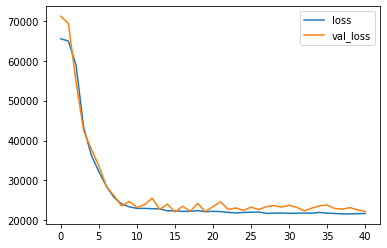

In [119]:
model_loss.plot()

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [121]:
#Make predictions
predicitions = model.predict(X_test)

In [122]:

mean_squared_error(y_test,predicitions)

22234.72

In [123]:
#RMS error
np.sqrt(mean_squared_error(y_test,predicitions))

149.11311

In [124]:
#mean absolute error
mean_absolute_error(y_test,predicitions)

80.99693

In [125]:
# Accurate to within 77 kWh

In [126]:
#best score is 1.0 -> how much variance is being explained by the model??
explained_variance_score(y_test,predicitions)

0.5546813011169434

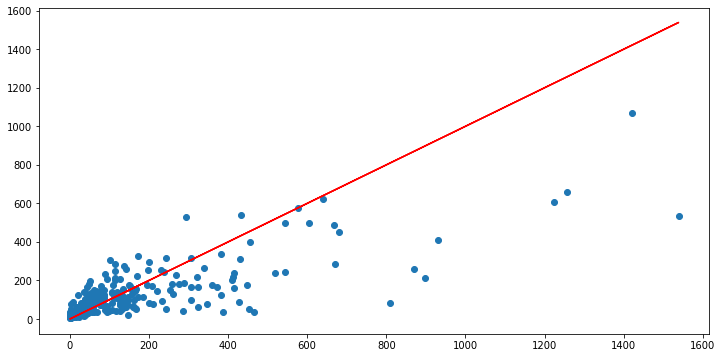

In [79]:
#Plot predicitions vs perfect fit
plt.figure(figsize=(12,6))
plt.scatter(y_test,predicitions)
plt.plot(y_test,y_test, 'r')


In [80]:
#Massive buildings are messing up the ANN

In [81]:
# Predicting the Test set results
y_pred = model.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[2.56e+02 1.99e+02]
 [5.62e+01 2.14e+01]
 [9.45e+01 8.47e+01]
 [7.12e+01 4.21e+01]
 [3.25e+02 1.71e+02]
 [4.52e+02 6.80e+02]
 [2.38e+02 5.18e+02]
 [4.77e+01 3.81e+01]
 [7.68e+01 1.45e+02]
 [3.08e+01 4.42e+01]
 [2.42e+01 1.38e+01]
 [1.13e+02 1.84e+02]
 [2.10e+01 9.26e+00]
 [9.49e+01 6.65e+01]
 [4.07e+01 1.17e+02]
 [9.12e+00 1.50e+01]
 [1.77e+02 1.09e+02]
 [4.34e+01 2.83e+01]
 [2.53e+02 2.30e+02]
 [3.63e+01 3.87e+02]
 [1.76e+02 1.94e+02]
 [1.39e+02 1.06e+02]
 [2.06e+02 9.40e+01]
 [4.27e+01 1.53e+01]
 [2.39e+01 1.77e+01]
 [1.04e+02 8.38e+01]
 [6.47e+01 2.41e+01]
 [1.02e+02 3.78e+01]
 [8.12e+01 7.13e+01]
 [1.13e+02 7.32e+01]
 [7.64e+01 3.41e+00]
 [8.74e+00 1.12e+01]
 [9.70e+01 1.46e+02]
 [3.27e+01 3.38e+01]
 [6.23e+01 5.90e+01]
 [2.74e+02 1.38e+02]
 [1.22e+02 2.13e+01]
 [2.44e+02 2.37e+02]
 [3.89e+01 1.59e+01]
 [8.07e+00 1.89e+00]
 [6.76e+01 5.17e+01]
 [1.00e+02 4.88e+01]
 [4.96e+01 2.43e+02]
 [2.03e+02 4.10e+02]
 [7.11e+01 8.20e+01]
 [1.42e+02 1.20e+02]
 [1.21e+02 4.81e+01]
 [1.58e+02 1.

In [82]:
assessment = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)

In [83]:
assessment = pd.DataFrame(data = assessment, columns = ['Predicted Mean Energy Usage', 'Real Mean Energy Output'])

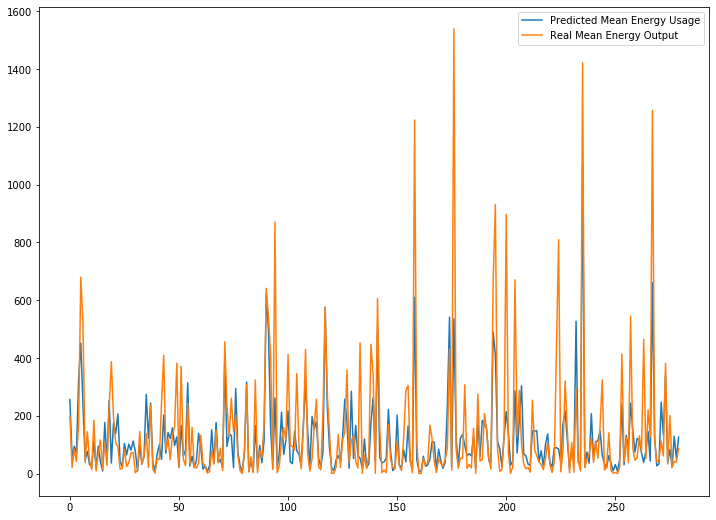

In [84]:
assessment.plot(figsize=(12,9))

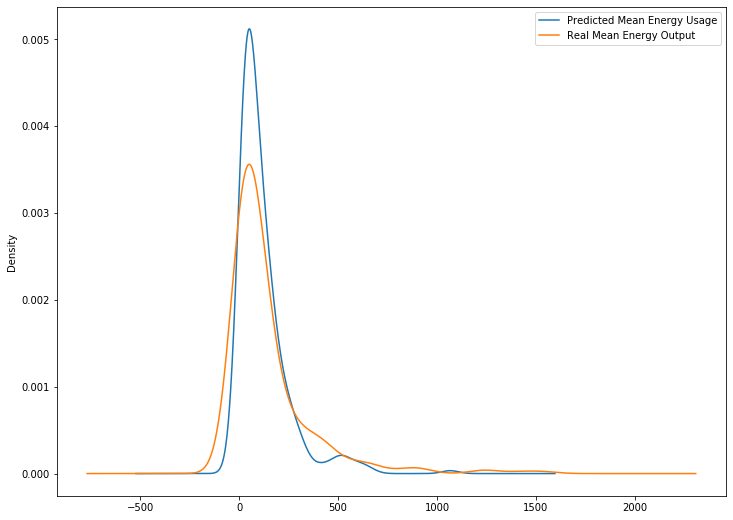

In [85]:
# Having a quick look at kernel density
assessment.plot(figsize=(12,9), kind ='kde')

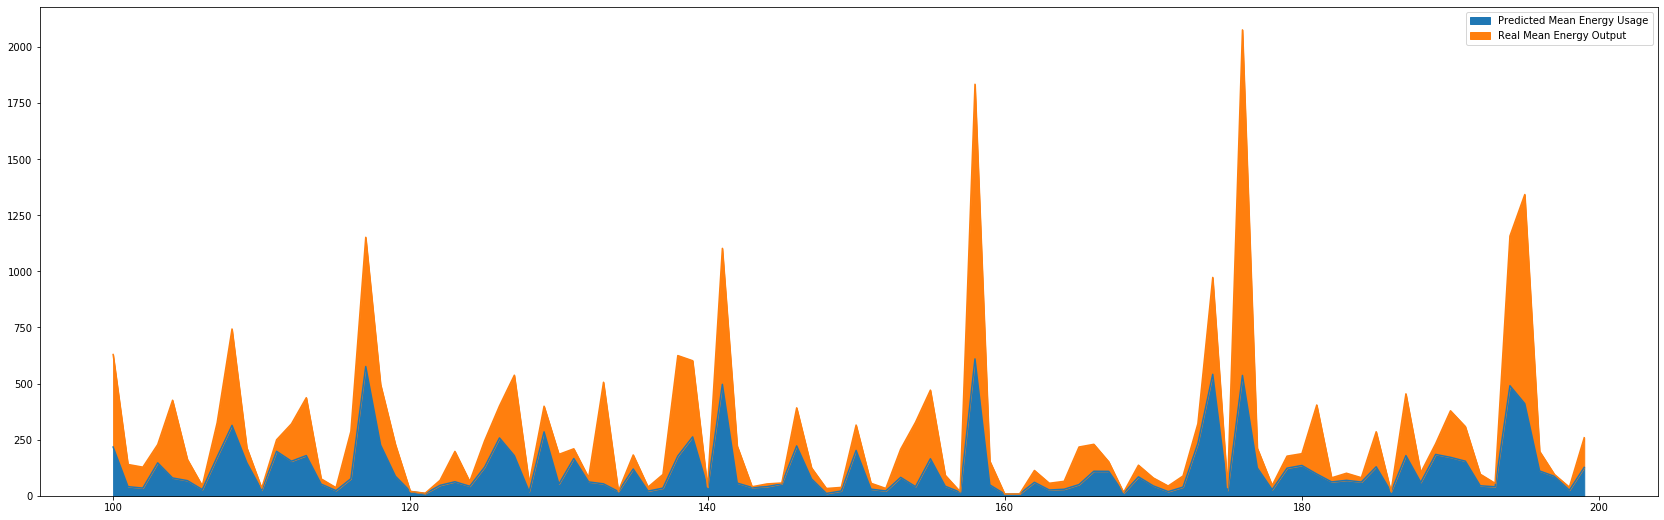

In [86]:
assessment[100:200].plot(figsize=(29,9),kind = 'area')

In [1351]:
# Building size and primary use can only explain 60% of energy consumption

In [1352]:
# 

In [92]:
assessment.describe()

,Predicted Mean Energy Usage,Real Mean Energy Output
count,280.000000,280.000000
mean,117.777985,147.616760
std,131.398773,222.872498
min,7.676769,0.171072
25%,36.774614,22.320308
50%,75.301044,62.393660
75%,147.972889,160.313248
max,1066.729980,1538.965820


In [95]:
new_cleaned['mean_usage'].mean()

146.56961059570312